# Clustering

In this notebook we do the three types of clustering discussed 

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

from libraries import clustering
from scipy.spatial.distance import squareform
from sklearn.cluster import DBSCAN
import numpy as np

In [2]:
DATASET_DIR = "dataset" + os.sep
RESULTS_DIR = "results" + os.sep

In [3]:
cyclist_distance_matrix_file = "cyclist_distance_matrix.lz4"
stages_distance_matrix_file = "stages_distance_matrix.lz4"
merged_distance_matrix_file = "merged_distance_matrix.lz4"

In [4]:
merged_df = pd.read_csv(DATASET_DIR + "merge_clean_v2.csv", parse_dates=["date"])
cyclist_df = pd.read_csv(DATASET_DIR + "cyclist_clean_v2.csv")
stages_df = pd.read_csv(DATASET_DIR + "stages_clean_v2.csv", parse_dates=["date"])

In [5]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589771 entries, 0 to 589770
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   _url               589771 non-null  object        
 1   points             589771 non-null  int64         
 2   length             589771 non-null  float64       
 3   profile            475349 non-null  float64       
 4   startlist_quality  589771 non-null  int64         
 5   date               589771 non-null  datetime64[ns]
 6   position           589771 non-null  int64         
 7   cyclist            589771 non-null  object        
 8   cyclist_age        589658 non-null  float64       
 9   delta              589771 non-null  int64         
 10  race               589771 non-null  object        
 11  year               589771 non-null  int64         
 12  stage              589771 non-null  object        
 13  birth_year         589724 non-null  float64 

In [8]:
cyclist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6095 entries, 0 to 6094
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _url         6095 non-null   object 
 1   name         6095 non-null   object 
 2   birth_year   6084 non-null   float64
 3   height       3134 non-null   float64
 4   nationality  6095 non-null   object 
 5   BMI          3134 non-null   float64
 6   continent    6095 non-null   object 
dtypes: float64(3), object(4)
memory usage: 333.4+ KB


In [9]:
stages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5281 entries, 0 to 5280
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   _url                   5281 non-null   object        
 1   stage                  5281 non-null   object        
 2   race                   5281 non-null   object        
 3   date                   5281 non-null   datetime64[ns]
 4   points                 5281 non-null   int64         
 5   length                 5281 non-null   int64         
 6   profile                3326 non-null   float64       
 7   startlist_quality      5281 non-null   int64         
 8   year                   5281 non-null   int64         
 9   season                 5281 non-null   object        
 10  cyclist_count_by_url   5281 non-null   int64         
 11  avg_age_by_url         5281 non-null   float64       
 12  avg_height_by_url      5281 non-null   float64       
 13  cyc

In [10]:
merged_df = merged_df.dropna()
cyclist_df = cyclist_df.dropna()
stages_df = stages_df.dropna()

In [11]:
cyclist_df.drop(columns=["name", "nationality"], inplace=True)
stages_df.drop(columns=["stage", "date", "race"], inplace=True)
merged_df.drop(columns=["date", "race", "stage", "nationality"], inplace=True)

merged_df.reset_index(drop=True, inplace=True)
cyclist_df.reset_index(drop=True, inplace=True)
stages_df.reset_index(drop=True, inplace=True)

In [12]:
cyclist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3134 entries, 0 to 3133
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   _url        3134 non-null   object 
 1   birth_year  3134 non-null   float64
 2   height      3134 non-null   float64
 3   BMI         3134 non-null   float64
 4   continent   3134 non-null   object 
dtypes: float64(3), object(2)
memory usage: 122.6+ KB


In [13]:
# transformation
transformed_cyclists_data, preprocessor_cyclists = clustering.transform(
    cyclist_df,
    categorical_cols=['continent'],
    standardize_cols=["height", "BMI"],
    minmax_cols=["birth_year"],
)

transformed_stages_data, preprocessor_stages = clustering.transform(
    stages_df,
    categorical_cols=["profile", "season"],
    minmax_cols=["year", "points", "length", "startlist_quality"],
)

# obtain df from the transformed data
# obtain df from the transformed data
transformed_cyclists_df = pd.DataFrame(transformed_cyclists_data)
transformed_stages_df = pd.DataFrame(transformed_stages_data)

# Add back the one-hot encoded columns
transformed_cyclists_df.columns = preprocessor_cyclists.get_feature_names_out(
    cyclist_df.columns
)
transformed_stages_df.columns = preprocessor_stages.get_feature_names_out(
    stages_df.columns
)


## TODO: put scaling of merged df here. The problem is that the values that are present in the other tables should be scaled in the same way as the other tables.
## Meaning that you cannot straightforward scale the merged df (frequency matters!!).

transformed_merged_data, preprocessor_merged = clustering.transform(
    merged_df,
    minmax_cols=[
        "position",
        "delta",
        "cyclist_age",
    ],
)

transformed_merged_df = pd.DataFrame(transformed_merged_data)
transformed_merged_df.columns = preprocessor_merged.get_feature_names_out(
    merged_df.columns
)

transformed_merged_df.reset_index(drop=True, inplace=True)
transformed_cyclists_df.reset_index(drop=True, inplace=True)
transformed_stages_df.reset_index(drop=True, inplace=True)

## add back the key columns
transformed_merged_df["_url"] = merged_df["_url"]
transformed_merged_df["cyclist"] = merged_df["cyclist"]
transformed_cyclists_df["_url"] = cyclist_df["_url"]
transformed_stages_df["_url"] = stages_df["_url"]

## TODO: When computing distances, DO NOT USE EUCLIDEAN on categorical data. Use a different distance metric. I have put gower in DBScan, but not in KMeans.

In [14]:
transformed_merged_df.info()
transformed_cyclists_df.info()
transformed_stages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402686 entries, 0 to 402685
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   minmax__position     402686 non-null  float64
 1   minmax__delta        402686 non-null  float64
 2   minmax__cyclist_age  402686 non-null  float64
 3   _url                 402686 non-null  object 
 4   cyclist              402686 non-null  object 
dtypes: float64(3), object(2)
memory usage: 15.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3134 entries, 0 to 3133
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   standardize__height           3134 non-null   float64
 1   standardize__BMI              3134 non-null   float64
 2   minmax__birth_year            3134 non-null   float64
 3   cat__continent_Africa         3134 non-null   float64
 4   cat__continent

In [15]:
# ok so categorical for merged is ok, still need to address non categorical. for non categorical copying from respective column in cyclist when cyclist == _url
# for column that is also present in stages, copying from stages, using _ulr == _url
# for the rest, they are unique to merged, so we can just left as it is


# actual fastest way is to use pd.merge

transformed_merged_df = pd.merge(
    transformed_merged_df,
    transformed_cyclists_df,
    left_on="cyclist",
    right_on="_url",
)
transformed_merged_df = pd.merge(
    transformed_merged_df,
    transformed_stages_df,
    left_on="_url_x",
    right_on="_url",
)

# now drop all uninteresting columns
transformed_merged_df.drop(
    columns=["_url_x", "_url_y", "cyclist", "_url"],
    inplace=True,
)
transformed_cyclists_df.drop(columns=["_url"], inplace=True)
transformed_stages_df.drop(columns=["_url"], inplace=True)

transformed_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402686 entries, 0 to 402685
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   minmax__position              402686 non-null  float64
 1   minmax__delta                 402686 non-null  float64
 2   minmax__cyclist_age           402686 non-null  float64
 3   standardize__height           402686 non-null  float64
 4   standardize__BMI              402686 non-null  float64
 5   minmax__birth_year            402686 non-null  float64
 6   cat__continent_Africa         402686 non-null  float64
 7   cat__continent_Asia           402686 non-null  float64
 8   cat__continent_Europe         402686 non-null  float64
 9   cat__continent_North America  402686 non-null  float64
 10  cat__continent_Oceania        402686 non-null  float64
 11  cat__continent_South America  402686 non-null  float64
 12  minmax__year                  402686 non-nul

Create a version of the dataframes without categorical columns

In [16]:
def filter_one_hot_columns(df):
    return df.loc[:, ~df.columns.str.startswith("cat__")]


real_cyclists_df = filter_one_hot_columns(transformed_cyclists_df)
real_stages_df = filter_one_hot_columns(transformed_stages_df)
real_merged_df = filter_one_hot_columns(transformed_merged_df)

real_cyclists_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3134 entries, 0 to 3133
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   standardize__height  3134 non-null   float64
 1   standardize__BMI     3134 non-null   float64
 2   minmax__birth_year   3134 non-null   float64
dtypes: float64(3)
memory usage: 73.6 KB


## K-means

Small tables can be analyzed easily since they don't require much memory. We can make deep analysis

In [23]:
kmeans_list, sse = clustering.kmeans_explore(real_cyclists_df, stride=1, max_k=100)
clustering.save_kmeans_results(kmeans_list, sse, RESULTS_DIR + "kmeans_cyclists.csv")

Computing KMeans for k=1
Computing KMeans for k=2
Computing KMeans for k=3
Computing KMeans for k=4
Computing KMeans for k=5
Computing KMeans for k=6
Computing KMeans for k=7
Computing KMeans for k=8
Computing KMeans for k=9
Computing KMeans for k=10
Computing KMeans for k=11
Computing KMeans for k=12
Computing KMeans for k=13
Computing KMeans for k=14
Computing KMeans for k=15
Computing KMeans for k=16
Computing KMeans for k=17
Computing KMeans for k=18
Computing KMeans for k=19
Computing KMeans for k=20
Computing KMeans for k=21
Computing KMeans for k=22
Computing KMeans for k=23
Computing KMeans for k=24
Computing KMeans for k=25
Computing KMeans for k=26
Computing KMeans for k=27
Computing KMeans for k=28
Computing KMeans for k=29
Computing KMeans for k=30
Computing KMeans for k=31
Computing KMeans for k=32
Computing KMeans for k=33
Computing KMeans for k=34
Computing KMeans for k=35
Computing KMeans for k=36
Computing KMeans for k=37
Computing KMeans for k=38
Computing KMeans for 

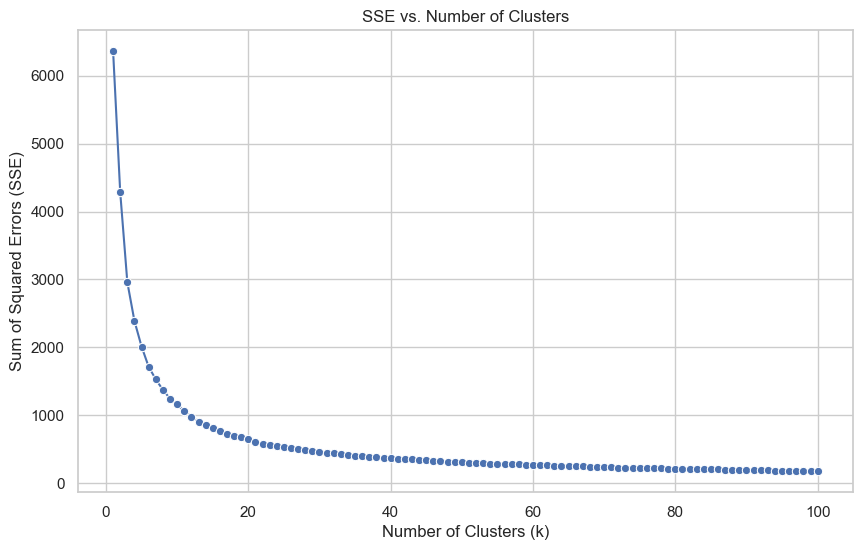

In [24]:
num_clusters = [kmeans.n_clusters for kmeans in kmeans_list]
clustering.plot_sse_vs_clusters(kmeans_list, sse)

Very bad scores on cyclists of silhouette

In [25]:
for kmeans in kmeans_list:
    try:
        print(silhouette_score(real_cyclists_df.values, kmeans.labels_))
    except ValueError:
        pass

0.30352392481743257
0.3239580574194679
0.3042314730239959
0.302668342386801
0.3078673913903396
0.3013612175934457
0.2987401050412191
0.2959965738798274
0.2869291931235721
0.2960677333850507
0.2959971940334111
0.2949245570555425
0.297653474610205
0.2927791214931041
0.29332998316940445
0.28991769252304317
0.2890502168873084
0.28065821396720086
0.285745271895563
0.288709683975545
0.29581500831899044
0.2903876780796854
0.29046847189858904
0.28925297875247047
0.2846898629372428
0.2858224974726805
0.27819323391969353
0.28745828708273674
0.28388952062063694
0.2838701649024975
0.27616805334781447
0.2770990229402709
0.2793206199435515
0.2806382732041344
0.2743144600599803
0.2754311487036872
0.275260423175173
0.27154105151663027
0.2672561522880756
0.27221878189749726
0.2740055178943914
0.27022125574672423
0.2692825688223372
0.274651158940978
0.27358204234127004
0.2757931114703169
0.26869859123088463
0.2751565783323579
0.27360222976898224
0.2637978141861576
0.26949470395323755
0.27574260063907385

#### Stages K-Means

In [26]:
kmeans_list, sse = clustering.kmeans_explore(real_stages_df, stride=1, max_k=100)
clustering.save_kmeans_results(kmeans_list, sse, RESULTS_DIR + "kmeans_stages.csv")

Computing KMeans for k=1
Computing KMeans for k=2
Computing KMeans for k=3
Computing KMeans for k=4
Computing KMeans for k=5
Computing KMeans for k=6
Computing KMeans for k=7
Computing KMeans for k=8
Computing KMeans for k=9
Computing KMeans for k=10
Computing KMeans for k=11
Computing KMeans for k=12
Computing KMeans for k=13
Computing KMeans for k=14
Computing KMeans for k=15
Computing KMeans for k=16
Computing KMeans for k=17
Computing KMeans for k=18
Computing KMeans for k=19
Computing KMeans for k=20
Computing KMeans for k=21
Computing KMeans for k=22
Computing KMeans for k=23
Computing KMeans for k=24
Computing KMeans for k=25
Computing KMeans for k=26
Computing KMeans for k=27
Computing KMeans for k=28
Computing KMeans for k=29
Computing KMeans for k=30
Computing KMeans for k=31
Computing KMeans for k=32
Computing KMeans for k=33
Computing KMeans for k=34
Computing KMeans for k=35
Computing KMeans for k=36
Computing KMeans for k=37
Computing KMeans for k=38
Computing KMeans for 

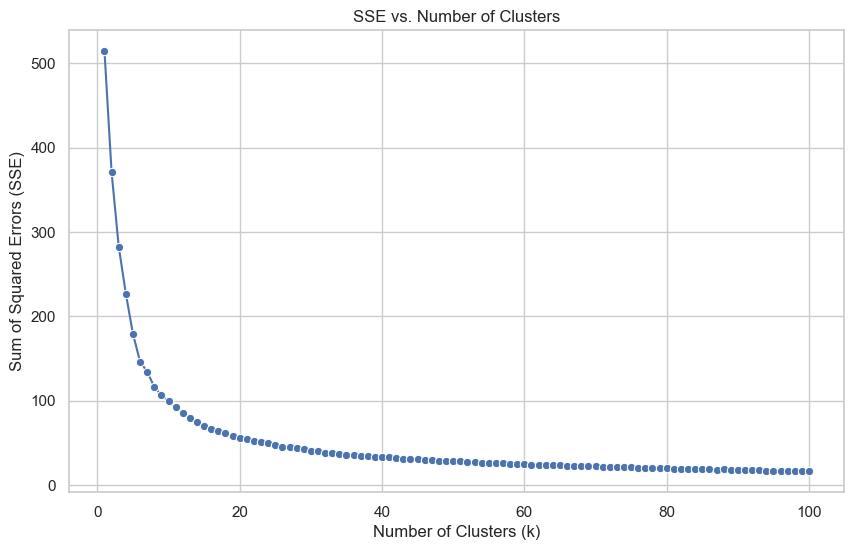

In [27]:
num_clusters = [kmeans.n_clusters for kmeans in kmeans_list]
clustering.plot_sse_vs_clusters(kmeans_list, sse)

Very bad silhoutte also on stages

In [29]:
for kmeans in kmeans_list:
    try:
        print(silhouette_score(real_stages_df.values, kmeans.labels_))
    except ValueError:
        pass

0.3117575967024595
0.3538100549832273
0.3754374096209195
0.3912055320970785
0.37864248056058836
0.3250265458464282
0.3586660126937024
0.35764523669845394
0.34918719676776994
0.3059557927627544
0.35032781007413705
0.3463256197187381
0.3264792269095236
0.3223598832558797
0.32020769581067837
0.3098970514620592
0.3119618753954046
0.31422586550101234
0.32237610049681376
0.3042135469172671
0.31508819910607017
0.311064060924332
0.2926205850885629
0.30551730691217754
0.30792105167028344
0.3063702439871799
0.2975252245978617
0.29263806103072976
0.29677210945016924
0.2968016461342231
0.29841823039526477
0.30250918625002093
0.2931209850477731
0.29782486830217947
0.29579189635830844
0.29768788816364183
0.2960548391007526
0.29767924713677557
0.2899071430674216
0.2864820686448251
0.2927424801505572
0.29171517097930355
0.2904962244727977
0.2895287556342984
0.2939885702749723
0.292062912648754
0.2930872980040951
0.29360153929874144
0.2918857712776486
0.2936583828127975
0.2826261674921762
0.28092640967

#### Merged K-Means

In [31]:
kmeans_list, sse = clustering.kmeans_explore(real_merged_df, stride=1, max_k=50)
clustering.save_kmeans_results(kmeans_list, sse, RESULTS_DIR + "kmeans_merged.csv")

Computing KMeans for k=1
Computing KMeans for k=2
Computing KMeans for k=3
Computing KMeans for k=4
Computing KMeans for k=5
Computing KMeans for k=6
Computing KMeans for k=7
Computing KMeans for k=8
Computing KMeans for k=9
Computing KMeans for k=10
Computing KMeans for k=11
Computing KMeans for k=12
Computing KMeans for k=13
Computing KMeans for k=14
Computing KMeans for k=15
Computing KMeans for k=16
Computing KMeans for k=17
Computing KMeans for k=18
Computing KMeans for k=19
Computing KMeans for k=20
Computing KMeans for k=21
Computing KMeans for k=22
Computing KMeans for k=23
Computing KMeans for k=24
Computing KMeans for k=25
Computing KMeans for k=26
Computing KMeans for k=27
Computing KMeans for k=28
Computing KMeans for k=29
Computing KMeans for k=30
Computing KMeans for k=31
Computing KMeans for k=32
Computing KMeans for k=33
Computing KMeans for k=34
Computing KMeans for k=35
Computing KMeans for k=36
Computing KMeans for k=37
Computing KMeans for k=38
Computing KMeans for 

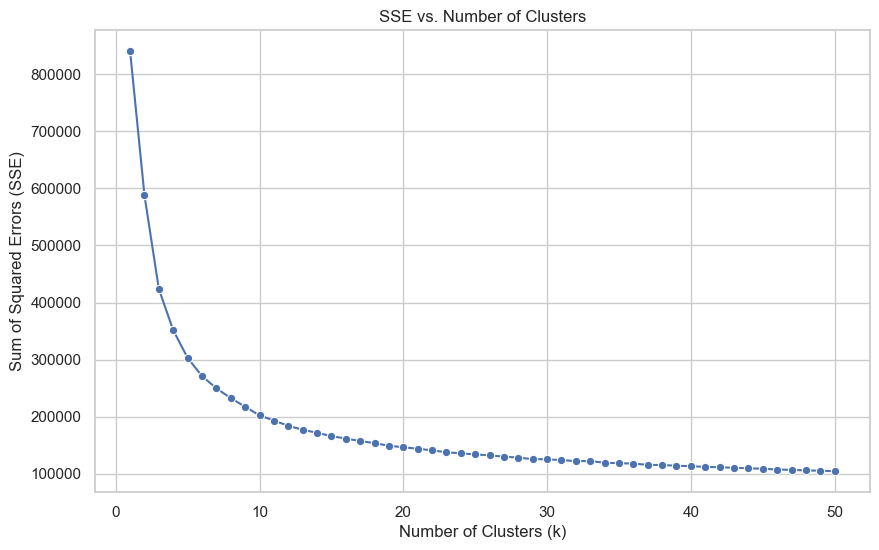

In [32]:
num_clusters = [kmeans.n_clusters for kmeans in kmeans_list]
clustering.plot_sse_vs_clusters(kmeans_list, sse)

## Hierarchical 

Define linkage methods to try

In [120]:
linkage_methods = ["single", "complete", "average", "ward", "centroid", "median"]

### Cyclists

Compute distance matrices for cyclists

In [121]:
dst_matrix_euclid = clustering.compute_distance_matrix(
    real_cyclists_df,
    "euclidean",
    cache_file=RESULTS_DIR + "euclidean-" + cyclist_distance_matrix_file,
)

# for gower you need binary array saying which columns are categorical
categorical_cols = transformed_cyclists_df.columns.str.startswith("cat__")

dst_matrix_gower = clustering.compute_distance_matrix(
    transformed_cyclists_df,
    "gower",
    cat_features=categorical_cols,
    cache_file=RESULTS_DIR + "gower-" + cyclist_distance_matrix_file,
)

compute hierarchical clustering

In [122]:
euclid_link = clustering.compute_hc(dst_matrix_euclid, methods=linkage_methods)
gower_link = clustering.compute_hc(
    dst_matrix_gower, methods=linkage_methods, is_square=True
)

Plot results

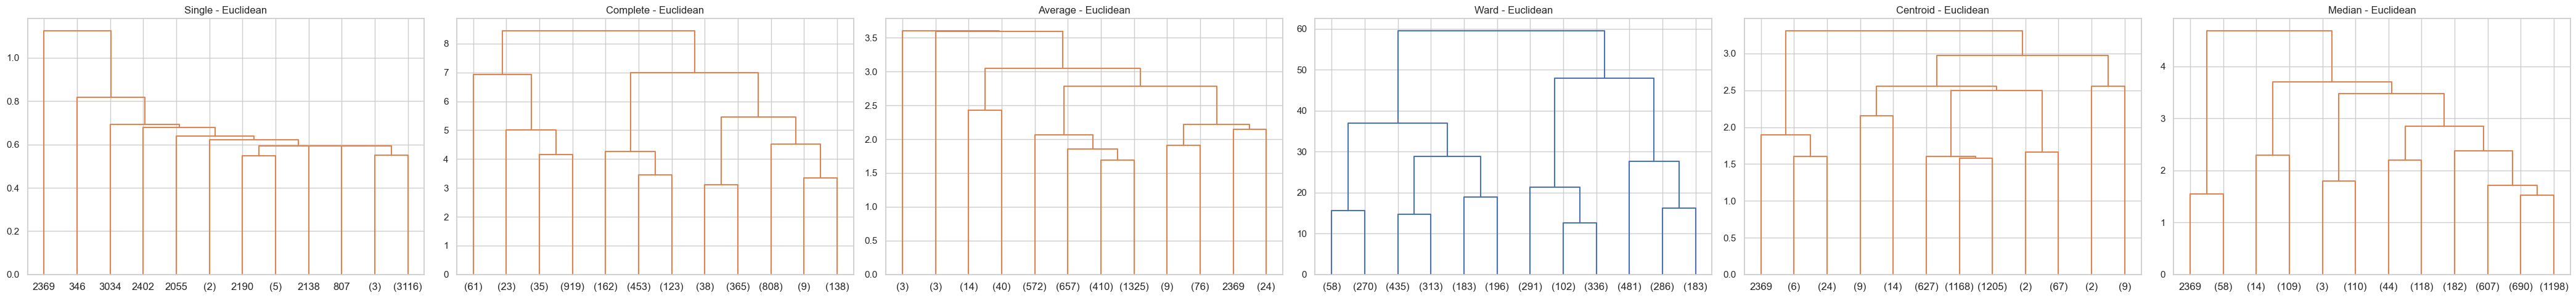

In [123]:
clustering.plot_all_hc(euclid_link, "euclidean")

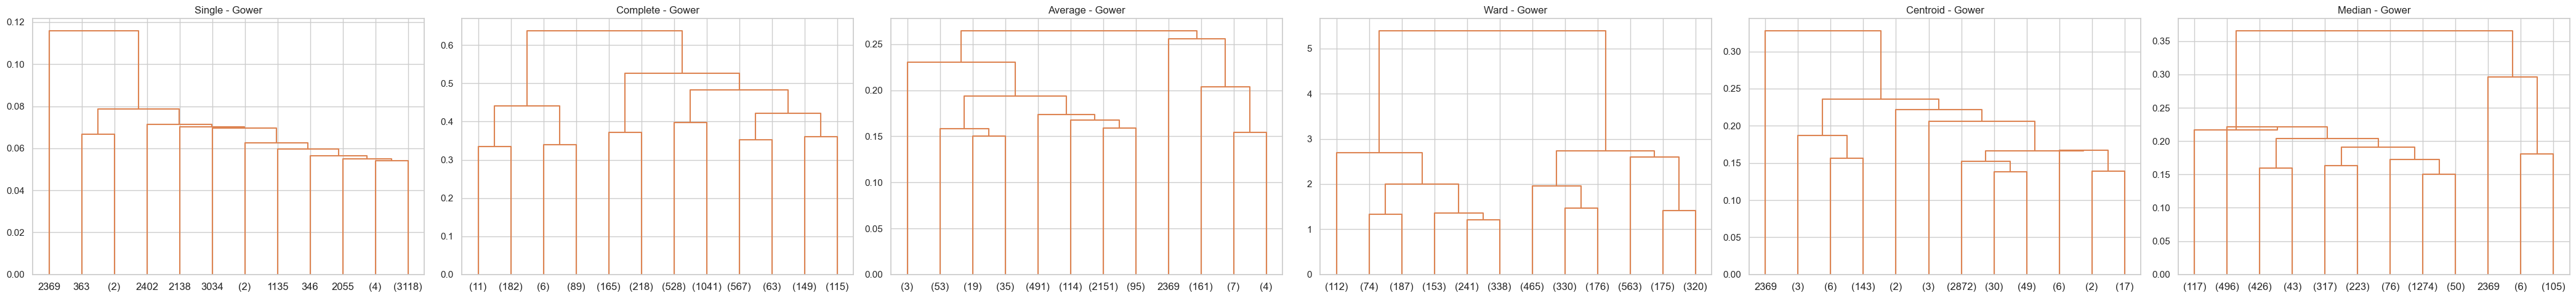

In [124]:
clustering.plot_all_hc(gower_link, "gower")

### Stages

In [125]:
dst_matrix_euclid = clustering.compute_distance_matrix(
    real_stages_df,
    "euclidean",
    cache_file=RESULTS_DIR + "euclidean-" + stages_distance_matrix_file,
)

# for gower you need binary array saying which columns are categorical
categorical_cols = transformed_stages_df.columns.str.startswith("cat__")
dst_matrix_gower = clustering.compute_distance_matrix(
    transformed_stages_df,
    "gower",
    cat_features=categorical_cols,
    cache_file=RESULTS_DIR + "gower-" + stages_distance_matrix_file,
)

In [126]:
euclid_link = clustering.compute_hc(dst_matrix_euclid, methods=linkage_methods)
gower_link = clustering.compute_hc(
    dst_matrix_gower, methods=linkage_methods, is_square=True
)

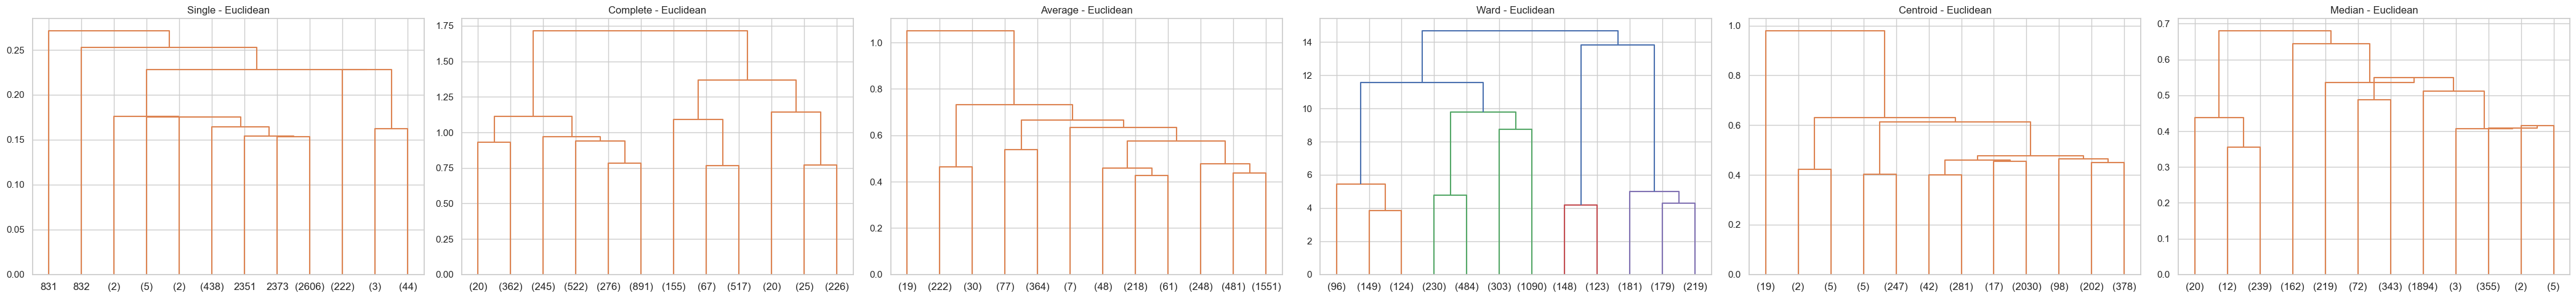

In [127]:
clustering.plot_all_hc(euclid_link, "euclidean")

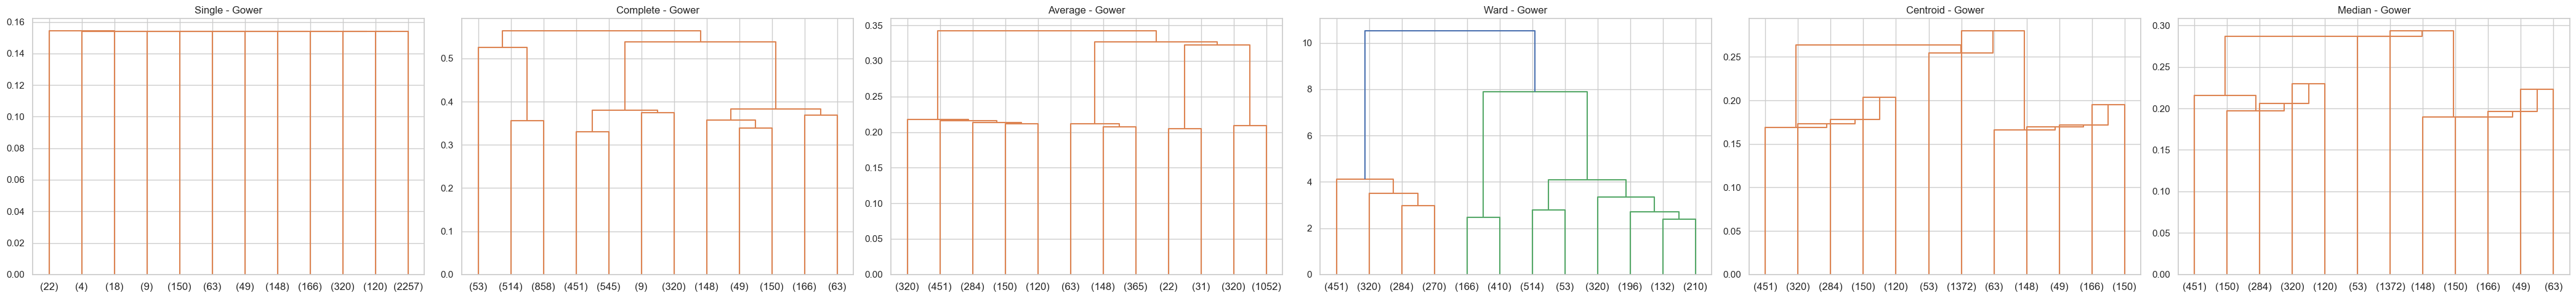

In [128]:
clustering.plot_all_hc(gower_link, "gower")

## DBscan

### Cyclists

In [15]:
dst_matrix_euclid = clustering.compute_distance_matrix(
    real_cyclists_df,
    "euclidean",
    cache_file=RESULTS_DIR + "euclidean-" + cyclist_distance_matrix_file,
)
dst_matrix_euclid = squareform(dst_matrix_euclid)

# for gower you need binary array saying which columns are categorical
categorical_cols = transformed_cyclists_df.columns.str.startswith("cat__")

dst_matrix_gower = clustering.compute_distance_matrix(
    transformed_cyclists_df,
    "gower",
    cat_features=categorical_cols,
    cache_file=RESULTS_DIR + "gower-" + cyclist_distance_matrix_file,
)
ks = [real_cyclists_df.shape[1] * 2, transformed_cyclists_df.shape[1] * 2]

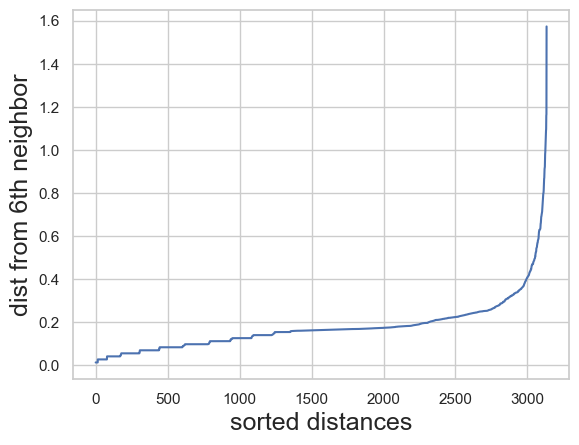

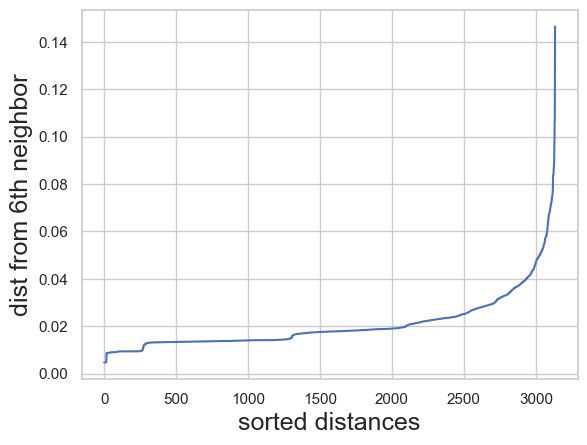

In [89]:
for dist, k in zip([dst_matrix_euclid, dst_matrix_gower], ks):
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])

    plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
    plt.ylabel("dist from %sth neighbor" % k, fontsize=18)
    plt.xlabel("sorted distances", fontsize=18)
    plt.show()

In [90]:
dbscan = DBSCAN(
    eps=0.3, min_samples=real_cyclists_df.shape[1] * 2, metric="precomputed"
)  # Hyperparameters: eps = look at graph, min_samples = dimensions * 2
labels = dbscan.fit_predict(dst_matrix_euclid)
transformed_cyclists_df["euclid_cluster"] = labels

In [91]:
dbscan = DBSCAN(
    eps=0.3, min_samples=transformed_cyclists_df.shape[1] * 2, metric="precomputed"
)  # Hyperparameters: eps = look at graph, min_samples = dimensions * 2
labels = dbscan.fit_predict(dst_matrix_gower)
transformed_cyclists_df["gower_cluster"] = labels

### Stages

In [16]:
dst_matrix_euclid = clustering.compute_distance_matrix(
    real_stages_df,
    "euclidean",
    cache_file=RESULTS_DIR + "euclidean-" + stages_distance_matrix_file,
)
dst_matrix_euclid = squareform(dst_matrix_euclid)
# for gower you need binary array saying which columns are categorical
categorical_cols = transformed_stages_df.columns.str.startswith("cat__")

dst_matrix_gower = clustering.compute_distance_matrix(
    transformed_stages_df,
    "gower",
    cat_features=categorical_cols,
    cache_file=RESULTS_DIR + "gower-" + stages_distance_matrix_file,
)
ks = [real_cyclists_df.shape[1] * 2, transformed_cyclists_df.shape[1] * 2]

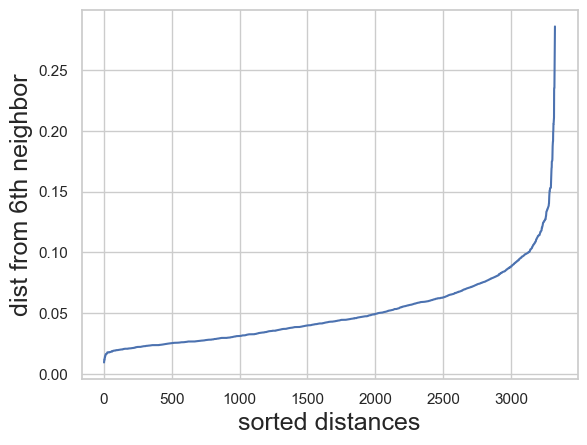

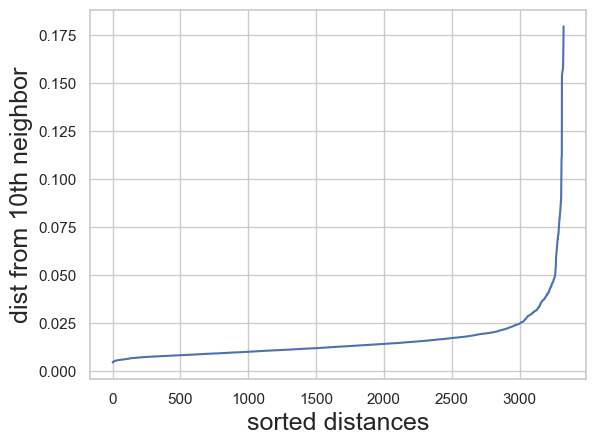

In [93]:
for dist, k in zip([dst_matrix_euclid, dst_matrix_gower], ks):
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])

    plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
    plt.ylabel("dist from %sth neighbor" % k, fontsize=18)
    plt.xlabel("sorted distances", fontsize=18)
    plt.show()

In [94]:
dbscan = DBSCAN(
    eps=0.07, min_samples=real_stages_df.shape[1] * 2, metric="precomputed"
)  # Hyperparameters: eps and min_samples can be adjusted
labels = dbscan.fit_predict(dst_matrix_euclid)
transformed_stages_df["euclid_cluster"] = labels

In [95]:
dbscan = DBSCAN(
    eps=0.02, min_samples=transformed_stages_df.shape[1] * 2, metric="precomputed"
)  # Hyperparameters: eps and min_samples can be adjusted
labels = dbscan.fit_predict(dst_matrix_gower)
transformed_stages_df["gower_cluster"] = labels